# Chapter 6: Best Practices for Model Evaluation andHyperparameter Tuning

## Import the data

In [2]:
import pandas as pd

In [3]:
df = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data', header=None)

Dataset is on breast cancer and is for classifying tumor as either malignant of benign.

In [4]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Sort the data set into features and targets.

In [5]:
from sklearn.preprocessing import LabelEncoder

In [6]:
X = df.loc[:, 2:].values
y = df.loc[:,1].values

In [7]:
le = LabelEncoder()
y = le.fit_transform(y)

Test encoding

In [8]:
le.transform(['M', 'B'])

array([1, 0], dtype=int64)

Check.

## Split into Test and Train Sets

In [9]:
from sklearn.cross_validation import train_test_split

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Combining Transformers into Pipeline

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

In [12]:
pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('pca', PCA(n_components=2)),
    ('clf', LogisticRegression(random_state=1))
])

In [13]:
pipe_lr.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scl', StandardScaler(copy=True, with_mean=True, with_std=True)), ('pca', PCA(copy=True, iterated_power='auto', n_components=2, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)), ('clf', LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=1, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False))])

In [14]:
print("Test Accuracy: {:.4f}".format(pipe_lr.score(X_test, y_test)))

Test Accuracy: 0.9474


That's not bad for such a small amount of work.

## Stratified K-Fold Cross Validation

In [15]:
import numpy as np
from sklearn.cross_validation import StratifiedKFold

In [16]:
kfold = StratifiedKFold(y=y_train,
                       n_folds=10,
                       random_state=1)
scores = []

In [17]:
for k, (train, test) in enumerate(kfold):
    pipe_lr.fit(X_train[train], y_train[train])
    score = pipe_lr.score(X_train[test], y_train[test])
    scores.append(score)
    print('Fold: {}, Class dist.: {}, Acc: {:.3}'.format(k+1, np.bincount(y_train[train]), score))

Fold: 1, Class dist.: [256 153], Acc: 0.891
Fold: 2, Class dist.: [256 153], Acc: 0.978
Fold: 3, Class dist.: [256 153], Acc: 0.978
Fold: 4, Class dist.: [256 153], Acc: 0.913
Fold: 5, Class dist.: [256 153], Acc: 0.935
Fold: 6, Class dist.: [257 153], Acc: 0.978
Fold: 7, Class dist.: [257 153], Acc: 0.933
Fold: 8, Class dist.: [257 153], Acc: 0.956
Fold: 9, Class dist.: [257 153], Acc: 0.978
Fold: 10, Class dist.: [257 153], Acc: 0.956


In [18]:
print('CV accuracy: {:.3f} +/- {:.3f}'.format(np.mean(scores), np.std(scores)))

CV accuracy: 0.950 +/- 0.029


## Debugging Algorithms with Learning and Validation Curves 

In [19]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.learning_curve import learning_curve

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\learning_curve.py:22: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the functions are moved. This module will be removed in 0.20
  DeprecationWarning)


In [20]:
pipe_lr = Pipeline([
    ('scl', StandardScaler()),
    ('clf', LogisticRegression(
        penalty='l2', random_state=0))
])

In [21]:
train_sizes, train_scores, test_scores = learning_curve(estimator=pipe_lr, 
                                                       X=X_train,
                                                       y=y_train,
                                                       train_sizes=np.linspace(0.1, 1.0, 10),
                                                       cv=10,
                                                       n_jobs=1)

In [22]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

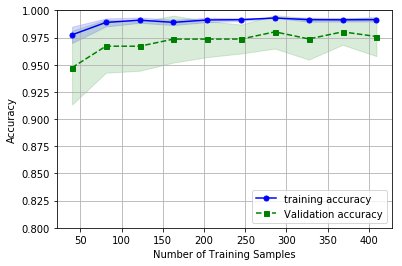

In [23]:
plt.plot(train_sizes, train_mean, color='blue',
        marker='o', markersize=5,
        label='training accuracy')
plt.fill_between(train_sizes, train_mean + train_std,
                train_mean - train_std, alpha=0.15,
                color='blue')
plt.plot(train_sizes, test_mean, color='green',
        marker='s', markersize=5, linestyle='--',
        label='Validation accuracy')
plt.fill_between(train_sizes, test_mean + test_std,
                test_mean - test_std, alpha=0.15,
                color='green')
plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.show()

## Addressing overfitting and underfitting with validation curves

In [24]:
from sklearn.learning_curve import validation_curve

In [25]:
param_range = [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]
train_scores, test_scores = validation_curve(
    estimator=pipe_lr,
    X=X_train,
    y=y_train,
    param_name='clf__C',
    param_range=param_range,
    cv=10
)

In [26]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)

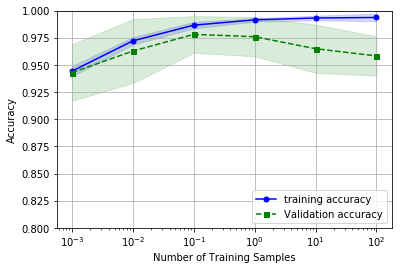

In [30]:
plt.plot(param_range, train_mean, color='blue',
        marker='o', markersize=5,
        label='training accuracy')
plt.fill_between(param_range, train_mean + train_std,
                train_mean - train_std, alpha=0.15,
                color='blue')
plt.plot(param_range, test_mean, color='green',
        marker='s', markersize=5, linestyle='--',
        label='Validation accuracy')
plt.fill_between(param_range, test_mean + test_std,
                test_mean - test_std, alpha=0.15,
                color='green')
plt.grid()
plt.xlabel('Number of Training Samples')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.ylim([0.8, 1.0])
plt.xscale('log')
plt.show()

## Fine-tuning machine learning models via grid search

In [32]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [36]:
pipe_svc = Pipeline([
    ('scl', StandardScaler()),
    ('clf', SVC(random_state=1))
])
param_range = [0.0001, 0.001, 0.01, 0.1, 1.0, 10.0, 100.0, 1000.0]
param_grid = [{'clf__C': param_range,'clf__kernel':['linear']},
              {'clf__C': param_range, 'clf__gamma': param_range,
              'clf__kernel':['rbf']}]

In [37]:
gs = GridSearchCV(estimator=pipe_svc,
                 param_grid=param_grid,
                 scoring='accuracy',
                 cv=10,
                 n_jobs=-1)

In [38]:
gs = gs.fit(X_train, y_train)

In [39]:
print(gs.best_score_)

0.978021978022


In [40]:
print(gs.best_params_)

{'clf__C': 0.1, 'clf__kernel': 'linear'}


In [41]:
clf = gs.best_estimator_
clf.fit(X_train, y_train)
print('Test Accuracy: {:.3f}'.format(clf.score(X_test, y_test)))

Test Accuracy: 0.965


## Algorithm selection with nested cross validation